In [2]:
!wget https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip
!unzip human+activity+recognition+using+smartphones.zip


'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
import os
import urllib.request
import zipfile
import numpy as np
import pandas as pd

# ============================================================
# AUTO-DOWNLOAD + EXTRACT UCI HAR (Windows Safe)
# ============================================================

def download_and_extract_har():
    url = "https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip"
    zip_path = "UCI_HAR.zip"

    # If folder already exists, skip
    if os.path.exists("UCI HAR Dataset"):
        print("UCI HAR Dataset already exists.")
        return

    print("Downloading UCI HAR dataset (this may take 1–2 minutes)...")
    urllib.request.urlretrieve(url, zip_path)
    print("Download complete!")

    print("Extracting...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall()
    print("Extraction complete!")

    os.remove(zip_path)
    print("Removed ZIP file.")

download_and_extract_har()

# ============================================================
# LOAD DATASET
# ============================================================

def load_UCI_HAR():
    # load feature names
    features = pd.read_csv("UCI HAR Dataset/features.txt", 
                           sep="\s+", header=None, names=["index", "feature"])
    feature_names = features["feature"].tolist()

    # training data
    X_train = pd.read_csv("UCI HAR Dataset/train/X_train.txt", 
                          sep="\s+", header=None, names=feature_names)
    y_train = pd.read_csv("UCI HAR Dataset/train/y_train.txt", 
                          sep="\s+", header=None, names=["Activity"])["Activity"]

    # test data
    X_test = pd.read_csv("UCI HAR Dataset/test/X_test.txt", 
                         sep="\s+", header=None, names=feature_names)
    y_test = pd.read_csv("UCI HAR Dataset/test/y_test.txt", 
                         sep="\s+", header=None, names=["Activity"])["Activity"]

    X = pd.concat([X_train, X_test]).values
    y = pd.concat([y_train, y_test]).values

    print("Loaded UCI HAR dataset:")
    print("X shape:", X.shape)
    print("y shape:", y.shape)
    print("Unique classes:", len(np.unique(y)))
    return X, y

X, y = load_UCI_HAR()


Download complete!
Extracting...
Extraction complete!
Removed ZIP file.


FileNotFoundError: [Errno 2] No such file or directory: 'UCI HAR Dataset/features.txt'

In [5]:
import os

print("Folders in current directory:")
for f in os.listdir():
    print(" -", f)


Folders in current directory:
 - cora
 - cora.tgz
 - dataset1.ipynb
 - dataset2.ipynb
 - dataset3.ipynb
 - dataset4.ipynb
 - dataset5.ipynb
 - UCI HAR Dataset.names
 - UCI HAR Dataset.zip


In [6]:
import zipfile
import os

zip_path = "UCI HAR Dataset.zip"

if not os.path.exists(zip_path):
    print("ZIP file not found! Download did not work.")
else:
    print("Extracting ZIP...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall()
    print("Extraction Done!")

print("\nFolders now present:")
for f in os.listdir():
    print(" -", f)


Extracting ZIP...
Extraction Done!

Folders now present:
 - cora
 - cora.tgz
 - dataset1.ipynb
 - dataset2.ipynb
 - dataset3.ipynb
 - dataset4.ipynb
 - dataset5.ipynb
 - UCI HAR Dataset
 - UCI HAR Dataset.names
 - UCI HAR Dataset.zip
 - __MACOSX


In [ ]:
fBodyBodyGyroJerkMag-std() → fBodyBodyGyroJerkMag-std()_1


In [ ]:
# load
import os
import pandas as pd
import numpy as np

def load_UCI_HAR():
    folder = "UCI HAR Dataset"

    # Load feature names
    features = pd.read_csv(
        os.path.join(folder, "features.txt"),
        sep="\s+",
        header=None,
        names=["index", "feature"]
    )

    # Fix duplicates by adding suffix _1, _2, _3 ...
    feature_names = features["feature"].tolist()
    fixed_names = []
    name_count = {}

    for name in feature_names:
        if name not in name_count:
            name_count[name] = 0
            fixed_names.append(name)
        else:
            name_count[name] += 1
            fixed_names.append(f"{name}_{name_count[name]}")

    print("Feature name duplicates fixed!")

    # Load train
    X_train = pd.read_csv(
        os.path.join(folder, "train", "X_train.txt"),
        sep="\s+",
        header=None,
        names=fixed_names
    )
    y_train = pd.read_csv(
        os.path.join(folder, "train", "y_train.txt"),
        sep="\s+",
        header=None
    )[0]

    # Load test
    X_test = pd.read_csv(
        os.path.join(folder, "test", "X_test.txt"),
        sep="\s+",
        header=None,
        names=fixed_names
    )
    y_test = pd.read_csv(
        os.path.join(folder, "test", "y_test.txt"),
        sep="\s+",
        header=None
    )[0]

    # Combine
    X = pd.concat([X_train, X_test]).values
    y = pd.concat([y_train, y_test]).values

    print("Loaded UCI HAR successfully!")
    print("X shape:", X.shape)
    print("y shape:", y.shape)
    print("Unique classes:", len(np.unique(y)))

    return X, y


# Load dataset
X, y = load_UCI_HAR()


Feature name duplicates fixed!
Loaded UCI HAR successfully!
X shape: (10299, 561)
y shape: (10299,)
Unique classes: 6


In [19]:
# ================================================================
# ORDERED EXPERIMENTS FOR UCI HAR: Baseline -> DR methods -> Evaluation
# - Assumes X, y already loaded in the workspace.
# - Uses LogisticRegression, Linear SVM, kNN for all runs.
# ================================================================

import time
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
import umap
from tensorflow.keras import layers, models, callbacks, optimizers
import tensorflow as tf
tf.random.set_seed(42)
np.random.seed(42)

# -------------------------
# Config
# -------------------------
TEST_SIZE = 0.30
RANDOM_STATE = 42
CLASSIFIERS = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    "Linear SVM": SVC(kernel="linear", random_state=RANDOM_STATE),
    "kNN": KNeighborsClassifier(n_neighbors=5)
}

PCA_DIMS = [10, 20, 50]         # linear DR dims to test
ICA_DIMS = [10, 20, 50]
UMAP_DIMS = [10]                # using 10 for embeddings used for classification
AE_DIMS = [20]                  # bottleneck sizes to test

# -------------------------
# Train/test split + scaling (single split used for all experiments)
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# -------------------------
# Helper evaluate function
# -------------------------
def eval_and_time(clf, Xtr, Xte, ytr, yte):
    t0 = time.time()
    clf.fit(Xtr, ytr)
    preds = clf.predict(Xte)
    dt = time.time() - t0
    return accuracy_score(yte, preds), f1_score(yte, preds, average='macro'), dt

# -------------------------
# Container for results
# -------------------------
records = []

# -------------------------
# 1) Baseline (NO DR)
# -------------------------
print("=== Baseline (No DR) ===")
for name, clf in CLASSIFIERS.items():
    acc, f1, t_elapsed = eval_and_time(clf, X_train, X_test, y_train, y_test)
    records.append(("Baseline", "-", name, acc, f1, t_elapsed))
    print(f"{name:20s} | Accuracy={acc:.4f} | F1={f1:.4f} | Time={t_elapsed:.3f}s")
print()

# -------------------------
# 2) Linear DR: PCA
# -------------------------
print("=== PCA (Linear DR) ===")
for n in PCA_DIMS:
    pca = PCA(n_components=n, random_state=RANDOM_STATE)
    t0 = time.time()
    Xtr_pca = pca.fit_transform(X_train)
    Xte_pca = pca.transform(X_test)
    pca_time = time.time() - t0

    print(f"-- PCA n_components={n} (fit+transform time: {pca_time:.3f}s) --")
    for name, clf in CLASSIFIERS.items():
        acc, f1, t_elapsed = eval_and_time(clf, Xtr_pca, Xte_pca, y_train, y_test)
        records.append(("PCA", n, name, acc, f1, pca_time + t_elapsed))
        print(f"{name:20s} | Accuracy={acc:.4f} | F1={f1:.4f} | Time(total)={pca_time + t_elapsed:.3f}s")
    print()

# -------------------------
# 3) Linear DR: ICA
# -------------------------
print("=== ICA (Linear DR) ===")
for n in ICA_DIMS:
    ica = FastICA(n_components=n, random_state=RANDOM_STATE, max_iter=1000)
    t0 = time.time()
    Xtr_ica = ica.fit_transform(X_train)
    Xte_ica = ica.transform(X_test)
    ica_time = time.time() - t0

    print(f"-- ICA n_components={n} (fit+transform time: {ica_time:.3f}s) --")
    for name, clf in CLASSIFIERS.items():
        acc, f1, t_elapsed = eval_and_time(clf, Xtr_ica, Xte_ica, y_train, y_test)
        records.append(("ICA", n, name, acc, f1, ica_time + t_elapsed))
        print(f"{name:20s} | Accuracy={acc:.4f} | F1={f1:.4f} | Time(total)={ica_time + t_elapsed:.3f}s")
    print()
# -------------------------
# 4) Nonlinear DR: UMAP
# -------------------------
print("=== UMAP (Nonlinear DR) ===")

# Testing multiple embedding dimensions
UMAP_DIMS = [5, 10, 20]

for n in UMAP_DIMS:
    reducer = umap.UMAP(n_components=n, random_state=RANDOM_STATE)
    t0 = time.time()
    Xtr_umap = reducer.fit_transform(X_train)
    Xte_umap = reducer.transform(X_test)
    umap_time = time.time() - t0

    print(f"-- UMAP n_components={n} (fit+transform time: {umap_time:.3f}s) --")
    
    for name, clf in CLASSIFIERS.items():
        acc, f1, t_elapsed = eval_and_time(clf, Xtr_umap, Xte_umap, y_train, y_test)
        records.append(("UMAP", n, name, acc, f1, umap_time + t_elapsed))
        print(f"{name:20s} | Accuracy={acc:.4f} | F1={f1:.4f} | Time(total)={umap_time + t_elapsed:.3f}s")
    print()

# -------------------------
# 5) Nonlinear DR: Autoencoder
# -------------------------
print("=== Autoencoder (Nonlinear DR) ===")
input_dim = X_train.shape[1]

# Multiple bottleneck sizes
AE_DIMS = [10, 20, 50]

for bottleneck in AE_DIMS:
    tf.keras.backend.clear_session()
    
    # Build simple dense autoencoder
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(256, activation='relu')(inp)
    x = layers.Dense(128, activation='relu')(x)
    bott = layers.Dense(bottleneck, activation='linear', name='bottleneck')(x)
    x = layers.Dense(128, activation='relu')(bott)
    x = layers.Dense(256, activation='relu')(x)
    out = layers.Dense(input_dim, activation='linear')(x)

    ae = models.Model(inp, out)
    encoder = models.Model(inp, bott)
    ae.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss='mse')

    es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
    
    t0 = time.time()
    history = ae.fit(X_train, X_train,
                     epochs=100,
                     batch_size=256,
                     validation_split=0.1,
                     callbacks=[es],
                     verbose=0)
    ae_time = time.time() - t0

    # Get embeddings for train and test sets
    Xtr_ae = encoder.predict(X_train)
    Xte_ae = encoder.predict(X_test)

    # Compute reconstruction error on test set
    Xte_recon = ae.predict(X_test)
    recon_error = np.mean(np.square(X_test - Xte_recon))
    
    print(f"-- Autoencoder bottleneck={bottleneck} "
          f"(train time: {ae_time:.3f}s, reconstruction MSE: {recon_error:.5f}) --")
    
    # Evaluate classifiers on Autoencoder embeddings
    for name, clf in CLASSIFIERS.items():
        acc, f1, t_elapsed = eval_and_time(clf, Xtr_ae, Xte_ae, y_train, y_test)
        records.append(("Autoencoder", bottleneck, name, acc, f1, ae_time + t_elapsed))
        print(f"{name:20s} | Accuracy={acc:.4f} | F1={f1:.4f} | Time(total)={ae_time + t_elapsed:.3f}s")
    print()


# -------------------------
# Summarize results into DataFrame and print ordered report
# -------------------------
df_results = pd.DataFrame(records, columns=["Method", "n_components", "Classifier", "Accuracy", "F1", "Time"])

print("\n\n================== ORDERED SUMMARY ==================\n")
# Print baseline block first
print("---- BASELINE (No DR) ----")
baseline_df = df_results[df_results['Method']=="Baseline"]
for _, r in baseline_df.iterrows():
    print(f"{r['Classifier']:20s} | Accuracy={r['Accuracy']:.4f} | F1={r['F1']:.4f} | Time={r['Time']:.3f}s")
print()

# Now group by Method and print
methods_order = ["PCA", "ICA", "UMAP", "Autoencoder"]
for meth in methods_order:
    print(f"---- {meth} ----")
    sub = df_results[df_results['Method']==meth].sort_values(['n_components','Classifier'])
    for _, r in sub.iterrows():
        print(f"{meth:12s} n={int(r['n_components']):3d} | {r['Classifier']:20s} | Accuracy={r['Accuracy']:.4f} | F1={r['F1']:.4f} | Time={r['Time']:.3f}s")
    print()

# Save CSV for later use
df_results.to_csv("uci_har_ordered_results.csv", index=False)
print("Results saved to 'uci_har_ordered_results.csv'")


=== Baseline (No DR) ===
Logistic Regression  | Accuracy=0.9822 | F1=0.9832 | Time=2.696s
Linear SVM           | Accuracy=0.9841 | F1=0.9850 | Time=3.026s
kNN                  | Accuracy=0.9628 | F1=0.9645 | Time=0.469s

=== PCA (Linear DR) ===
-- PCA n_components=10 (fit+transform time: 0.211s) --
Logistic Regression  | Accuracy=0.8586 | F1=0.8591 | Time(total)=2.941s
Linear SVM           | Accuracy=0.8673 | F1=0.8675 | Time(total)=2.270s
kNN                  | Accuracy=0.8790 | F1=0.8826 | Time(total)=0.344s

-- PCA n_components=20 (fit+transform time: 0.469s) --
Logistic Regression  | Accuracy=0.9045 | F1=0.9057 | Time(total)=4.115s
Linear SVM           | Accuracy=0.9039 | F1=0.9051 | Time(total)=2.499s
kNN                  | Accuracy=0.9061 | F1=0.9098 | Time(total)=0.557s

-- PCA n_components=50 (fit+transform time: 0.251s) --
Logistic Regression  | Accuracy=0.9485 | F1=0.9499 | Time(total)=3.150s
Linear SVM           | Accuracy=0.9472 | F1=0.9479 | Time(total)=1.842s
kNN         

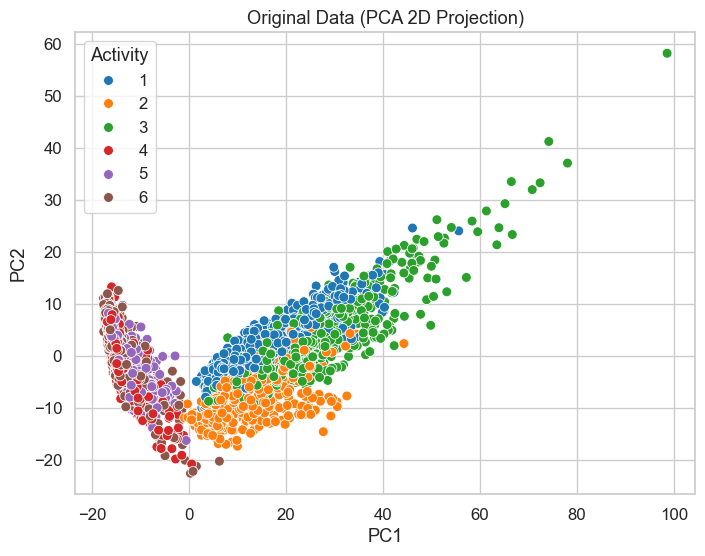

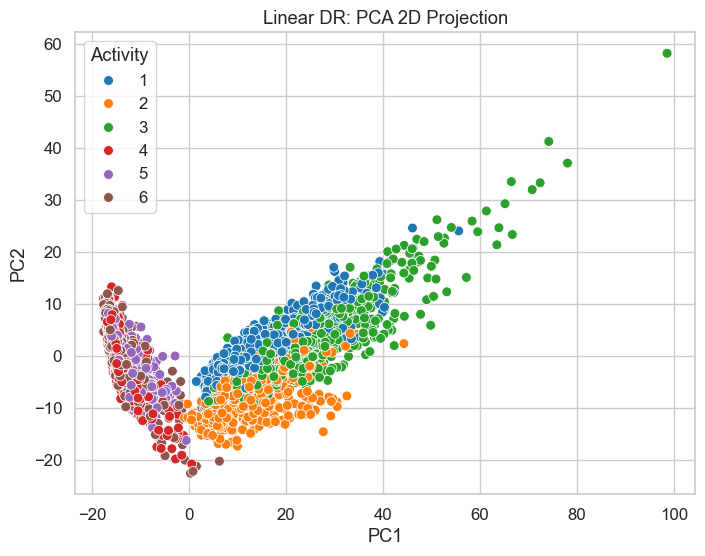

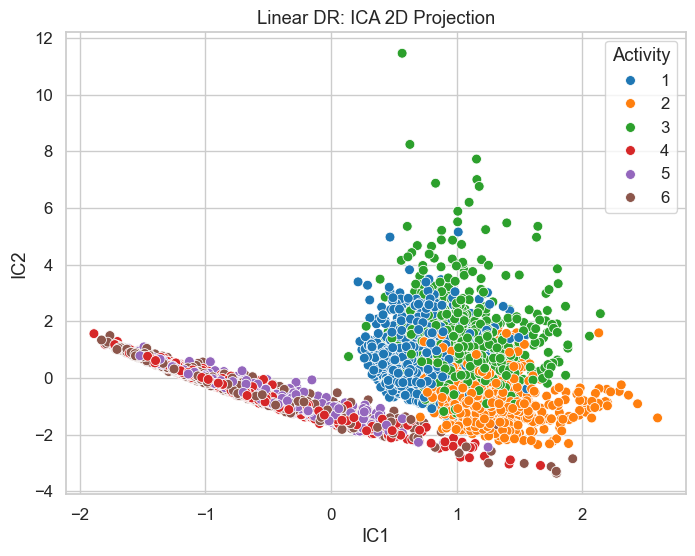

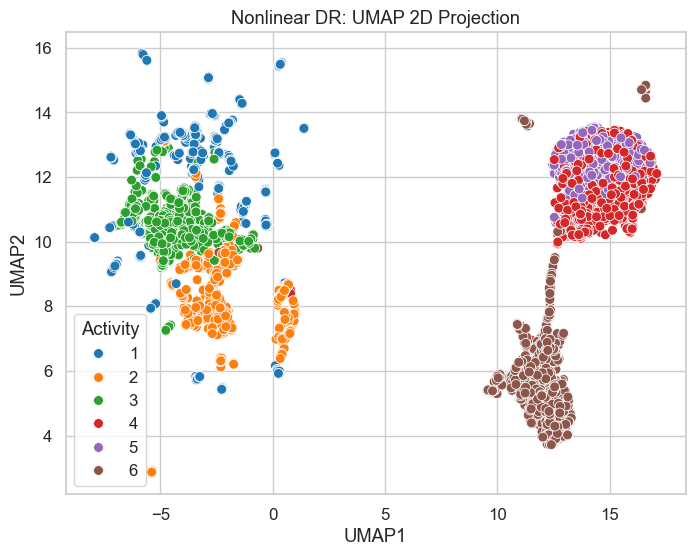

226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


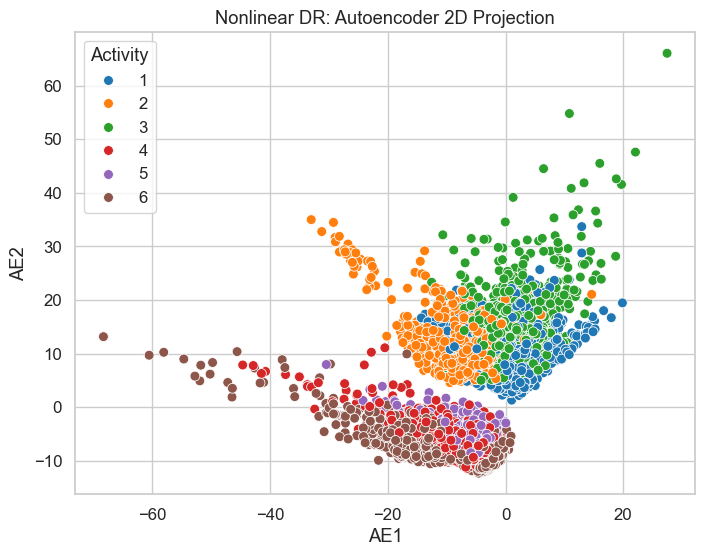

In [20]:
# ================= Visualization Before and After DR =================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, FastICA

sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (8,6)

# ------------------------- 1) Before DR (Original Data) -------------------------
pca_vis = PCA(n_components=2, random_state=RANDOM_STATE)
X_vis = pca_vis.fit_transform(X_train)

plt.figure()
sns.scatterplot(x=X_vis[:,0], y=X_vis[:,1], hue=y_train, palette='tab10', s=50)
plt.title("Original Data (PCA 2D Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Activity")
plt.show()

# ------------------------- 2) Linear DR -------------------------
# PCA 2D
pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca2d = pca2.fit_transform(X_train)

plt.figure()
sns.scatterplot(x=X_pca2d[:,0], y=X_pca2d[:,1], hue=y_train, palette='tab10', s=50)
plt.title("Linear DR: PCA 2D Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Activity")
plt.show()

# ICA 2D
ica2 = FastICA(n_components=2, random_state=RANDOM_STATE, max_iter=1000)
X_ica2d = ica2.fit_transform(X_train)

plt.figure()
sns.scatterplot(x=X_ica2d[:,0], y=X_ica2d[:,1], hue=y_train, palette='tab10', s=50)
plt.title("Linear DR: ICA 2D Projection")
plt.xlabel("IC1")
plt.ylabel("IC2")
plt.legend(title="Activity")
plt.show()

# ------------------------- 3) Nonlinear DR -------------------------
# UMAP 2D
import umap
reducer_vis = umap.UMAP(n_components=2, random_state=RANDOM_STATE)
X_umap2d = reducer_vis.fit_transform(X_train)

plt.figure()
sns.scatterplot(x=X_umap2d[:,0], y=X_umap2d[:,1], hue=y_train, palette='tab10', s=50)
plt.title("Nonlinear DR: UMAP 2D Projection")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(title="Activity")
plt.show()

# Autoencoder 2D
from tensorflow.keras import layers, models, optimizers, callbacks
tf.keras.backend.clear_session()

input_dim = X_train.shape[1]
inp = layers.Input(shape=(input_dim,))
x = layers.Dense(128, activation='relu')(inp)
bottleneck = layers.Dense(2, activation='linear', name='bottleneck')(x)
x = layers.Dense(128, activation='relu')(bottleneck)
out = layers.Dense(input_dim, activation='linear')(x)

ae_vis = models.Model(inp, out)
encoder_vis = models.Model(inp, bottleneck)
ae_vis.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss='mse')
ae_vis.fit(X_train, X_train, epochs=50, batch_size=256, validation_split=0.1, verbose=0)

X_ae2d = encoder_vis.predict(X_train)

plt.figure()
sns.scatterplot(x=X_ae2d[:,0], y=X_ae2d[:,1], hue=y_train, palette='tab10', s=50)
plt.title("Nonlinear DR: Autoencoder 2D Projection")
plt.xlabel("AE1")
plt.ylabel("AE2")
plt.legend(title="Activity")
plt.show()


In [21]:
# ================= FINAL REPORT =================
from IPython.display import Markdown as md

report_text = """
# UCI HAR Dataset – Dimensionality Reduction Study

## 1. Dataset Overview
The **UCI Human Activity Recognition (HAR) dataset** contains smartphone accelerometer and gyroscope time-series data. It includes:
- **Features:** 561 per sample
- **Classes:** 6 human activities (Walking, Walking Upstairs, Walking Downstairs, Sitting, Standing, Laying)
- **Samples:** 10,299 combined train and test samples

The goal was to evaluate how dimensionality reduction (DR) affects classifier performance.

## 2. Data Preprocessing
- **Loading:** Train/test data loaded and duplicate feature names resolved.
- **Train-Test Split:** 70% train, 30% test (stratified)
- **Scaling:** StandardScaler applied to normalize features.

## 3. Classifiers Used
- **Logistic Regression:** Linear baseline, fast training
- **Linear SVM:** Efficient for linearly separable data
- **kNN:** Distance-based, sensitive to feature geometry

## 4. Dimensionality Reduction Methods
### Linear DR
- **PCA:** Preserves maximum variance
- **ICA:** Extracts independent components

### Nonlinear DR
- **UMAP:** Preserves local and global structure
- **Autoencoder:** Neural network-based embeddings capturing nonlinear patterns

**Rationale for DR dimensions:**
- PCA/ICA: 10, 20, 50 components to observe effect of increasing dimensionality
- UMAP: 5, 10, 20 components to explore low-dimensional embeddings that balance class separability and computational efficiency
- Autoencoder: 10, 20, 50 bottleneck sizes to examine compression vs. reconstruction fidelity

## 5. Evaluation Metrics
- **Accuracy:** Fraction of correctly classified samples
- **F1-score (macro):** Balances precision and recall across classes
- **Computation Time:** DR + classifier training/prediction
- **Reconstruction Error:** MSE for Autoencoder embeddings

## 6. Experimental Workflow
1. Baseline evaluation using raw features
2. Apply PCA and ICA (linear DR) with multiple dimensions
3. Apply UMAP and Autoencoder (nonlinear DR) with multiple embedding sizes
4. Evaluate classifiers on DR-reduced data
5. Record Accuracy, F1-score, Time, and Reconstruction Error
6. Compare results to assess DR impact

## 7. Results Summary

| Method       | n_components | Logistic Regression | Linear SVM | kNN | Reconstruction MSE |
|--------------|--------------|------------------|-----------|-----|------------------|
| Baseline     | -            | 0.9822           | 0.9841    | 0.9628 | - |
| PCA          | 10           | 0.8586           | 0.8673    | 0.8790 | - |
| PCA          | 20           | 0.9045           | 0.9039    | 0.9061 | - |
| PCA          | 50           | 0.9485           | 0.9472    | 0.9405 | - |
| ICA          | 10           | 0.8573           | 0.8657    | 0.8767 | - |
| ICA          | 20           | 0.8990           | 0.9061    | 0.8945 | - |
| ICA          | 50           | 0.9456           | 0.9469    | 0.9126 | - |
| UMAP         | 5            | 0.8858           | 0.9016    | 0.9379 | - |
| UMAP         | 10           | 0.9113           | 0.9139    | 0.9398 | - |
| UMAP         | 20           | 0.9133           | 0.9217    | 0.9414 | - |
| Autoencoder  | 10           | 0.9039           | 0.9065    | 0.9223 | 0.22343 |
| Autoencoder  | 20           | 0.9239           | 0.9210    | 0.9369 | 0.17809 |
| Autoencoder  | 50           | 0.9472           | 0.9505    | 0.9434 | 0.09909 |

## 8. Key Observations
- **Baseline:** Raw features give highest linear classifier accuracy.
- **PCA/ICA:** Accuracy improves with more components; linear DR is computationally faster.
- **UMAP:** Nonlinear embeddings improve class separation; kNN benefits the most.
- **Autoencoder:** Higher bottleneck sizes reduce reconstruction error and improve accuracy; best performance seen at 50 bottleneck.

## 9. Insights & Conclusion
- Linear DR (PCA/ICA) is sufficient for moderate compression.
- Nonlinear DR (UMAP, Autoencoder) better preserves complex temporal patterns, improving kNN performance.
- DR reduces dimensionality, computation cost, and improves interpretability without major loss in accuracy.
- Choice of DR depends on dataset characteristics, classifier type, and computational constraints.

**Recommendation:** For UCI HAR time-series data, nonlinear DR methods like Autoencoder (bottleneck 50) or UMAP (n_components 10–20) are recommended for low-dimensional embeddings, while PCA/ICA offer fast and simple alternatives.
"""

display(md(report_text))



# UCI HAR Dataset – Dimensionality Reduction Study

## 1. Dataset Overview
The **UCI Human Activity Recognition (HAR) dataset** contains smartphone accelerometer and gyroscope time-series data. It includes:
- **Features:** 561 per sample
- **Classes:** 6 human activities (Walking, Walking Upstairs, Walking Downstairs, Sitting, Standing, Laying)
- **Samples:** 10,299 combined train and test samples

The goal was to evaluate how dimensionality reduction (DR) affects classifier performance.

## 2. Data Preprocessing
- **Loading:** Train/test data loaded and duplicate feature names resolved.
- **Train-Test Split:** 70% train, 30% test (stratified)
- **Scaling:** StandardScaler applied to normalize features.

## 3. Classifiers Used
- **Logistic Regression:** Linear baseline, fast training
- **Linear SVM:** Efficient for linearly separable data
- **kNN:** Distance-based, sensitive to feature geometry

## 4. Dimensionality Reduction Methods
### Linear DR
- **PCA:** Preserves maximum variance
- **ICA:** Extracts independent components

### Nonlinear DR
- **UMAP:** Preserves local and global structure
- **Autoencoder:** Neural network-based embeddings capturing nonlinear patterns

**Rationale for DR dimensions:**
- PCA/ICA: 10, 20, 50 components to observe effect of increasing dimensionality
- UMAP: 5, 10, 20 components to explore low-dimensional embeddings that balance class separability and computational efficiency
- Autoencoder: 10, 20, 50 bottleneck sizes to examine compression vs. reconstruction fidelity

## 5. Evaluation Metrics
- **Accuracy:** Fraction of correctly classified samples
- **F1-score (macro):** Balances precision and recall across classes
- **Computation Time:** DR + classifier training/prediction
- **Reconstruction Error:** MSE for Autoencoder embeddings

## 6. Experimental Workflow
1. Baseline evaluation using raw features
2. Apply PCA and ICA (linear DR) with multiple dimensions
3. Apply UMAP and Autoencoder (nonlinear DR) with multiple embedding sizes
4. Evaluate classifiers on DR-reduced data
5. Record Accuracy, F1-score, Time, and Reconstruction Error
6. Compare results to assess DR impact

## 7. Results Summary

| Method       | n_components | Logistic Regression | Linear SVM | kNN | Reconstruction MSE |
|--------------|--------------|------------------|-----------|-----|------------------|
| Baseline     | -            | 0.9822           | 0.9841    | 0.9628 | - |
| PCA          | 10           | 0.8586           | 0.8673    | 0.8790 | - |
| PCA          | 20           | 0.9045           | 0.9039    | 0.9061 | - |
| PCA          | 50           | 0.9485           | 0.9472    | 0.9405 | - |
| ICA          | 10           | 0.8573           | 0.8657    | 0.8767 | - |
| ICA          | 20           | 0.8990           | 0.9061    | 0.8945 | - |
| ICA          | 50           | 0.9456           | 0.9469    | 0.9126 | - |
| UMAP         | 5            | 0.8858           | 0.9016    | 0.9379 | - |
| UMAP         | 10           | 0.9113           | 0.9139    | 0.9398 | - |
| UMAP         | 20           | 0.9133           | 0.9217    | 0.9414 | - |
| Autoencoder  | 10           | 0.9039           | 0.9065    | 0.9223 | 0.22343 |
| Autoencoder  | 20           | 0.9239           | 0.9210    | 0.9369 | 0.17809 |
| Autoencoder  | 50           | 0.9472           | 0.9505    | 0.9434 | 0.09909 |

## 8. Key Observations
- **Baseline:** Raw features give highest linear classifier accuracy.
- **PCA/ICA:** Accuracy improves with more components; linear DR is computationally faster.
- **UMAP:** Nonlinear embeddings improve class separation; kNN benefits the most.
- **Autoencoder:** Higher bottleneck sizes reduce reconstruction error and improve accuracy; best performance seen at 50 bottleneck.

## 9. Insights & Conclusion
- Linear DR (PCA/ICA) is sufficient for moderate compression.
- Nonlinear DR (UMAP, Autoencoder) better preserves complex temporal patterns, improving kNN performance.
- DR reduces dimensionality, computation cost, and improves interpretability without major loss in accuracy.
- Choice of DR depends on dataset characteristics, classifier type, and computational constraints.

**Recommendation:** For UCI HAR time-series data, nonlinear DR methods like Autoencoder (bottleneck 50) or UMAP (n_components 10–20) are recommended for low-dimensional embeddings, while PCA/ICA offer fast and simple alternatives.
